### Ryan v Atkin (soil moisture and large size init) v forest plot data 

#### Load libraries

In [1]:
import numpy as np
import xarray as xr
import csv
import pandas as pd

import functions_py.fates_xarray_functions as fa
import functions_py.fates_nearest_gridcell as ngc


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import Normalize


In [2]:
pfts = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']


# colours for canopy/understory and FATES/Data
dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

In [3]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


### Comparison with plot data

#### Load sparse grid FATES

In [10]:
# Ryan 1991 (last ten years of  300 year run)
fates_ryan ='/compyfs/need138/elm_runs/calibration/fbnc/atkin/base_ryan/run/base_ryan.elm.h0.fullrun.nc'

#fates_ryan = '/compyfs/need138/elm_runs/calibration/fbnc/atkin/Ryan_f45_f45.Eb645be3-F1c7ec09.2023-05-05/run/lnd/hist/Ryan_f45_f45.Eb645be3-F1c7ec09.2023-05-05.elm.h0.2295-01-01-00000.nc'
fates_def = xr.open_dataset(fates_ryan,  decode_times=False)
time = fates_def.variables['time']/365.

nyears = int(len(fates_def.variables['time'])/12)
n_lat = len(fates_def.variables['lat'])
n_lon = len(fates_def.variables['lon'])

tave_start = (nyears-5)*12
tave_stop = nyears*12

cohort_size_bins = fates_def.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

# Atkin  
fates_atkin='/compyfs/need138/elm_runs/calibration/fbnc/atkin/fbnc_atkin_base_b645be3_1c7ec09.2023-05-04/run/lnd/hist/fbnc_atkin_base_b645be3_1c7ec09.2023-05-04.elm.h0.2300-02-01-00000.nc'
#fates_atkin =  '/compyfs/need138/elm_runs/calibration/fbnc/atkin/Atkin_f45_f45.Eb645be3-F1c7ec09.2023-05-05/run/lnd/hist/Atkin_f45_f45.Eb645be3-F1c7ec09.2023-05-05.elm.h0.2295-01-01-00000.nc'
fates_new = xr.open_dataset(fates_atkin, decode_times=False)


In [11]:
df = pd.read_csv('/qfs/people/need138/plot_data/Galbraith_etal_2013_table_S1.csv')

# for plots with the same lat and lon use the mean of AGB, AWP and Tau
df['mean_AGB'] = df.groupby(['Lat','Lon'])['AGB (MgDM)'].transform('mean')
df['mean_AWP'] = df.groupby(['Lat','Lon'])['AWP (Mg DM year-1)'].transform('mean')
df['mean_tau'] = df.groupby(['Lat','Lon'])['Residence Time (years)'].transform('mean')

df = df.drop_duplicates(subset = ['Lat','Lon','mean_AGB'], keep = 'last').reset_index(drop=True)

lat = np.array(df['Lat'])
lon_negs = np.array(df['Lon'])
lon = [x%360 for x in lon_negs]

# AGB
plot_agb = np.array(df['mean_AGB'])
plot_agb = plot_agb * 1000 / 10000 / 2 # Mg ha-1 of biomass to kg m-2 of Carbon  

# AWP
plot_awp = np.array(df['mean_AWP'])
plot_awp = plot_awp * 1000 / 10000 / 2 # Mg ha-1 of biomass to kg m-2 of Carbon 

# tau
plot_tau = np.array(df['mean_tau'])


In [12]:
# Mid points of each grid cell
range_lat = 180
range_lon = 360
width_lat = range_lat/n_lat
width_lon = range_lon/n_lon
min_lat = fates_def.coords['lat'][0]
min_lon = fates_def.coords['lon'][0]
min_mid_lat = min_lat + width_lat/2
min_mid_lon = min_lon + width_lon/2

mid_lat = min_mid_lat.values + (width_lat * np.arange(n_lat))
mid_lon = min_mid_lon.values + (width_lon * np.arange(n_lon))

n_plots=len(lat) # number of sites
min_grids = np.empty((n_plots,2),int) # array to hold index of nearest grid cells for each plot

for k in range(0, n_plots) :
    min_grids[k,:] = ngc.find_nearest_grid(lat[k], lon[k], mid_lat, mid_lon)
    
# get indeces
lat_ind = min_grids[:,0]
lon_ind = min_grids[:,1]
    
# These are on a -90 to 90 and 0 to 360 scale
plot_mid_lats = mid_lat[lat_ind]
plot_mid_lons = mid_lon[lon_ind]

# Transform back to -90 to 90 and -180 to 180 for plotting
fig_plot_mid_lats = plot_mid_lats
fig_plot_mid_lons = [-1*(360-x) if x > 180 else x for x in plot_mid_lons]
                     
x = xr.DataArray(lat_ind, dims = ['location'])
y = xr.DataArray(lon_ind, dims = ['location'])



#### Check large size initialisation is  working 

In [7]:
fates_atkin_start = '/compyfs/need138/elm_runs/calibration/fbnc/atkin/fbnc_atkin_base_b645be3_1c7ec09.2023-05-04/run/lnd/hist/tmp/fbnc_atkin_base_b645be3_1c7ec09.2023-05-04.elm.h0.firstthirty.nc'
fates_new_start = xr.open_dataset(fates_atkin_start, decode_times=False)

fates_ryan_start = '/compyfs/need138/elm_runs/calibration/fbnc/atkin/base_ryan/run/tmp/base_ryan.elm.h0.firstthirty.nc'
fates_ryan_start = xr.open_dataset(fates_ryan_start, decode_times=False)

In [8]:
nyears = int(len(fates_new_start.variables['time']))
time_start = fates_new_start.variables['time']/365

In [9]:
nplant = fa.scpf_to_scls_by_pft(fates_new_start.FATES_NPLANT_SZPF, fates_new_start).isel(lat=x,lon=y)
nplant = nplant.isel(time=0)
nplant = nplant.isel(fates_levpft=0)

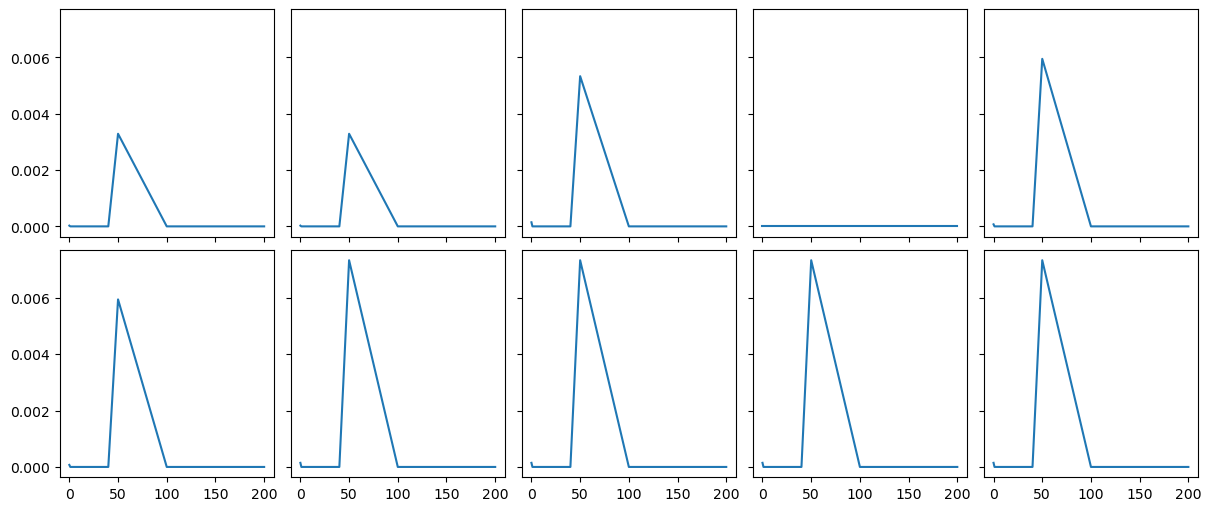

In [10]:
fig, axs = plt.subplots(nrows=2,ncols=5,
                        figsize=(12,5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,10) :
     axs[i].plot(cohort_size_bins,  nplant[i,:])

In [11]:
nplant_def = fa.scpf_to_scls_by_pft(fates_ryan_start.FATES_NPLANT_SZPF, fates_ryan_start).isel(lat=x,lon=y)
nplant_def = nplant_def.isel(time=0)
nplant_def = nplant_def.isel(fates_levpft=0)

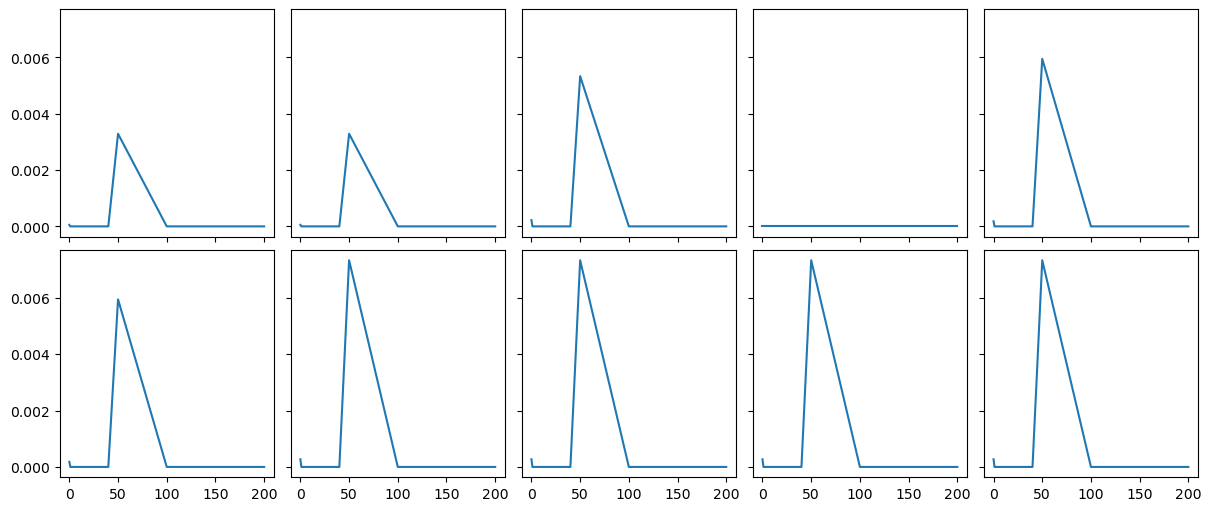

In [12]:
fig, axs = plt.subplots(nrows=2,ncols=5,
                        figsize=(12,5), sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,10) :
     axs[i].plot(cohort_size_bins,  nplant_def[i,:])

### Biomass in first thirty five years

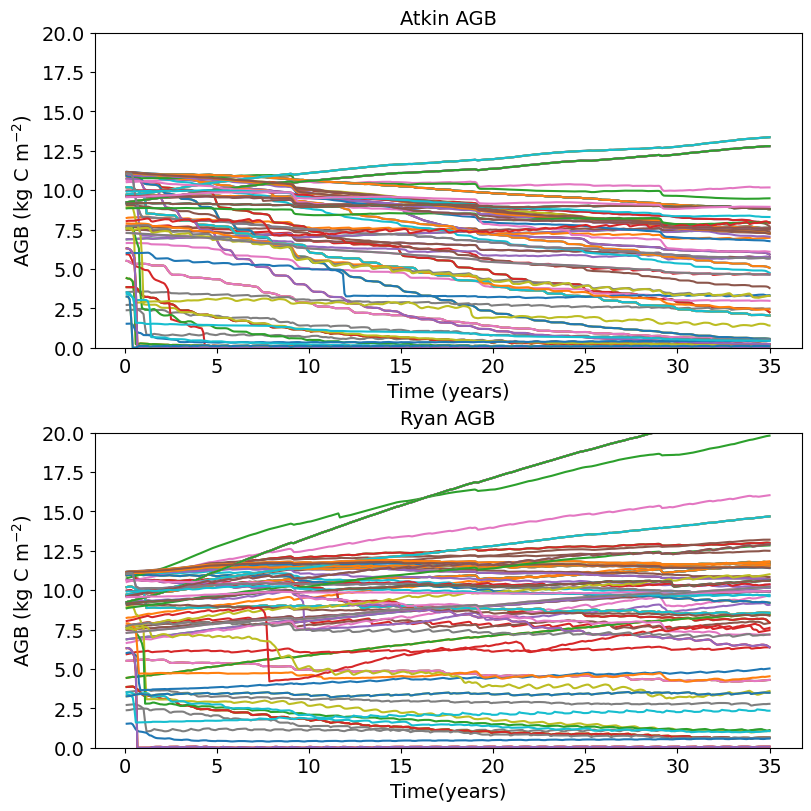

In [13]:
agb = fates_new_start.FATES_VEGC_ABOVEGROUND_SZPF.sum(dim='fates_levscpf')
agb = agb.isel(lat=x,lon=y)

agb_def = fates_ryan_start.FATES_VEGC_ABOVEGROUND_SZPF.sum(dim='fates_levscpf')
agb_def = agb_def.isel(lat=x,lon=y)

fig2, ((f2ax0, f2ax1)) = plt.subplots(nrows=2,ncols=1, figsize=(8,8), constrained_layout=True)

# AGB 
# colour coded by latitude
f2ax0.plot(time_start, agb)
f2ax0.set_title(r'Atkin AGB', fontsize = 14)
f2ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 14)
f2ax0.set_xlabel(r'Time (years)', fontsize = 14)
f2ax0.tick_params(labelsize=14)
f2ax0.set_ylim(0,20)

f2ax1.plot(time_start, agb_def)
f2ax1.set_title(r'Ryan AGB', fontsize = 14)
f2ax1.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 14)
f2ax1.set_xlabel(r'Time(years)', fontsize = 14)
f2ax1.tick_params(labelsize=14)
f2ax1.set_ylim(0,20)

plt.savefig("Figures/AGB_ryan_atkin_time.png", format = 'png', dpi = 300, facecolor='white', edgecolor='white')


### Comparisons with field data

In [13]:
# AGB - total
agb_def = fa.scpf_to_scls_by_pft(fates_def.FATES_VEGC_ABOVEGROUND_SZPF, fates_def).mean(dim='time')
agb_def = agb_def.isel(fates_levscls = slice(1,nsizebins))
agb_def = agb_def.isel(lat=x,lon=y)
agb_def = agb_def.sum(dim='fates_levscls') 
agb_def = agb_def.sum(dim='fates_levpft')

# AWP - total
# delete the  first size bin
awp_def = fa.scpf_to_scls_by_pft(fates_def.FATES_ABOVEGROUND_PROD_SZPF, fates_def)* 86400 * 365 # s-1 to yr-1
awp_def = awp_def.isel(fates_levscls = slice(1,nsizebins))
awp_def = awp_def.isel(lat=x,lon=y).mean(dim='time')
awp_def = awp_def.sum(dim='fates_levscls') 
awp_def = awp_def.sum(dim='fates_levpft')

# Tau - total
fates_tau_def = agb_def/awp_def

# # AGB - total
agb_new = fa.scpf_to_scls_by_pft(fates_new.FATES_VEGC_ABOVEGROUND_SZPF, fates_new).mean(dim='time')
agb_new = agb_new.isel(fates_levscls = slice(1,nsizebins))
agb_new = agb_new.isel(lat=x,lon=y)
agb_new = agb_new.sum(dim='fates_levscls') 
agb_new = agb_new.sum(dim='fates_levpft')

# # AWP - total
awp_new = fa.scpf_to_scls_by_pft(fates_new.FATES_ABOVEGROUND_PROD_SZPF, fates_new) * 86400 * 365 # s-1 to yr-1
awp_new = awp_new.isel(fates_levscls = slice(1,nsizebins))
awp_new = awp_new.isel(lat=x,lon=y).mean(dim='time')
awp_new = awp_new.sum(dim='fates_levscls')
awp_new = awp_new.sum(dim='fates_levpft')

# # Tau - total
fates_tau_new = agb_new/awp_new

In [ ]:
fig2, ((f2ax0, f2ax1),(f2ax2,f2ax3),(f2ax4,f2ax5)) = plt.subplots(nrows=3,ncols=2, figsize=(9,9),
                                                                 constrained_layout=True)
# AGB 
# colour coded by latitude
f2ax0.scatter(plot_agb, agb_def, c=abs(lat))
f2ax0.set_title(r'AGB - Ryan et al. 1991', fontsize = 12)
f2ax0.set_ylabel(r'FATES AGB (kg C m$^{-2}$)', fontsize = 10)
f2ax0.set_xlabel(r'Plot AGB (kg C m$^{-2}$)', fontsize = 10, labelpad=0)
f2ax0.plot(np.arange(30), np.arange(30), color = 'lightgrey', linestyle='dashed')
f2ax0.tick_params(labelsize=10)
f2ax0.set_ylim(0,33)
f2ax0.set_xlim(0,33)
root_mean_sq_err = rmse(agb_def, plot_agb).values.round(3)
f2ax0.text(2, 30, 'RMSE:{0}'.format(root_mean_sq_err),fontsize = 10)

f2ax1.scatter(plot_agb, agb_new, c=abs(lat))
f2ax1.set_title(r'AGB - Atkin et al. 2017', fontsize = 12)
#f2ax1.set_ylabel(r'FATES AGB (kg C m$^{-2}$)', fontsize = 10)
f2ax1.set_xlabel(r'Plot AGB (kg C m$^{-2}$)', fontsize = 10)
f2ax1.plot(np.arange(30), np.arange(30), color = 'lightgrey', linestyle='dashed')
f2ax1.tick_params(labelsize=10)
f2ax1.set_ylim(0,33)
f2ax1.set_xlim(0,33)
root_mean_sq_err = rmse(agb_new, plot_agb).values.round(3)
f2ax1.text(2, 30, 'RMSE:{0}'.format(root_mean_sq_err),fontsize = 10)


# AWP 
f2ax2.scatter(plot_awp, awp_def, c=abs(lat), cmap='viridis')
f2ax2.set_title(r'AWP - Ryan et al. 1991', fontsize = 12)
f2ax2.set_ylabel(r'FATES AWP (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax2.set_xlabel(r'Plot AWP (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax2.plot(np.linspace(0,0.8,10), np.linspace(0,0.8,10), color = 'lightgrey', linestyle='dashed')
f2ax2.tick_params(labelsize=10)
f2ax2.set_ylim(0,1)
root_mean_sq_err = rmse(awp_def, plot_awp).values.round(3)
f2ax2.text(0.02, 0.9, 'RMSE:{0}'.format(root_mean_sq_err),fontsize = 10)


# AWP 
f2ax3.scatter(plot_awp, awp_new, c=abs(lat), cmap='viridis')
f2ax3.set_title(r'AWP - Atkin et al. 2017', fontsize = 12)
#f2ax3.set_ylabel(r'FATES AWP (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax3.set_xlabel(r'Plot AWP (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 10)
f2ax3.plot(np.linspace(0,0.8,10), np.linspace(0,0.8,10), color = 'lightgrey', linestyle='dashed')
f2ax3.tick_params(labelsize=10)
f2ax3.set_ylim(0,1)
root_mean_sq_err = rmse(awp_new, plot_awp).values.round(3)
f2ax3.text(0.02, 0.9, 'RMSE:{0}'.format(root_mean_sq_err),fontsize = 10)


# Tau
f2ax4.scatter(plot_tau, fates_tau_def, c=abs(lat), cmap='viridis')
f2ax4.set_title(r'C residence time - Ryan et al. 1991', fontsize = 12)
f2ax4.set_ylabel(r'FATES tau (years)', fontsize = 10)
f2ax4.set_xlabel(r'Plot tau (years)', fontsize = 10)
f2ax4.plot(np.linspace(0,120,10), np.linspace(0,120,10), color = 'lightgrey', linestyle='dashed')
f2ax4.tick_params(labelsize=10)
root_mean_sq_err = rmse(fates_tau_def, plot_tau).values.round(3)
f2ax4.text(1, 110, 'RMSE:{0}'.format(root_mean_sq_err),fontsize = 10)


# AWM
sc = f2ax5.scatter(plot_tau, fates_tau_new, c=abs(lat), cmap='viridis')
f2ax5.set_title(r'C residence time - Atkin et al. 2017', fontsize = 12)
#f2ax5.set_ylabel(r'FATES tau (years)', fontsize = 10)
f2ax5.set_xlabel(r'Plot tau (years)', fontsize = 10)
f2ax5.plot(np.linspace(0,120,10), np.linspace(0,120,10), color = 'lightgrey', linestyle='dashed')
f2ax5.tick_params(labelsize=10)
root_mean_sq_err = rmse(fates_tau_new, plot_tau).values.round(3)
f2ax5.text(1, 110, 'RMSE:{0}'.format(root_mean_sq_err),fontsize = 10)


# Add a colorbar axis at the bottom of the graph
cbar_ax = fig2.add_axes([0.2, -0.025, 0.6, 0.02])

# Draw the colorbar
cbar=fig2.colorbar(sc, cax=cbar_ax,orientation='horizontal')
cbar.set_label('Latitude (absolute)', fontsize=10)

plt.savefig("Figures/galbraith_ryan_atkin_sparse.png", format = 'png', dpi = 300, facecolor='white', edgecolor='white')


### Load piponiot size-dependent data

For each site calculate difference between AWP and AWM and AGB in fates v plot data. 
Make figures showing
1) example site with Atkin and Ryan
2) distributions of errors?  

In [16]:
data = pd.read_csv('/qfs/people/need138/plot_data/Piponiot_2022_NewPhyt_AGB_AWP_AWM_standard_size_class.csv')
data.head(5)

,site,variable,size_class,total,lower_bound,upper_bound
0,Amacayacu,AGB,"[1,5)",4.667,4.577,4.756
1,Amacayacu,AGB,"[5,10)",13.352,13.066,13.625
2,Amacayacu,AGB,"[10,20)",40.574,39.664,41.437
3,Amacayacu,AGB,"[20,30)",45.710,43.989,47.473
4,Amacayacu,AGB,"[30,40)",47.076,44.335,49.988


In [17]:
name = 'Korup'
# just keep the site of interest
plotdata = data[data['site'] == name]
AGB = np.array(plotdata[plotdata["variable"] == 'AGB']['total'])
AWP = np.array(plotdata[plotdata["variable"] == 'AWP']['total'])
AWM = np.array(plotdata[plotdata["variable"] == 'AWM']['total'])
 
# If some of the size classes are missing add zeros
# plot size classes are 1 to 300 (filled in with zeros)
if (not len(AGB) == 9) :
    zeros = np.repeat(np.array([0]), [9 - len(AGB)], axis=0)
    AGB = np.append(AGB,zeros)
    AWP = np.append(AWP,zeros)
    AWM = np.append(AWM,zeros)
    
print(AWP.shape)  

print(plotdata.head(3))

(9,)
      site variable size_class   total  lower_bound  upper_bound
198  Korup      AGB      [1,5)   7.150        6.996        7.277
199  Korup      AGB     [5,10)  14.580       14.268       14.854
200  Korup      AGB    [10,20)  36.042       35.135       36.914


In [18]:
n_lat = len(fates_new.variables['lat'])
n_lon = len(fates_new.variables['lon'])
lati = [9.15]
loni = [-79.85]
loni = np.mod(loni, 360)

# Mid points of each grid cell
range_lat = 180
range_lon = 360
width_lat = range_lat/n_lat
width_lon = range_lon/n_lon
min_lat = fates_new.coords['lat'][0]
min_lon = fates_new.coords['lon'][0]
min_mid_lat = min_lat + width_lat/2
min_mid_lon = min_lon + width_lon/2

mid_lat = min_mid_lat.values + (width_lat * np.arange(n_lat))
mid_lon = min_mid_lon.values + (width_lon * np.arange(n_lon))
tmp = ngc.find_nearest_grid(lati, loni, mid_lat, mid_lon)
    
# get indeces
lat_ind = int(tmp[0])
lon_ind = int(tmp[1])

plot_mid_lats = mid_lat[lat_ind]
plot_mid_lons = mid_lon[lon_ind]

print(plot_mid_lats)
print(plot_mid_lons)

8.4375
281.25


In [19]:
# AGB - by size
agb = fa.scpf_to_scls_by_pft(fates_new.FATES_VEGC_ABOVEGROUND_SZPF, fates_new)
agb = agb.isel(lat = lat_ind, lon=lon_ind).mean(dim='time')
agb = agb.isel(fates_levscls=slice(1,nsizebins)).sum(dim='fates_levpft')

# AWM
awm_sz_by_pft = fa.scpf_to_scls_by_pft(fates_new.FATES_ABOVEGROUND_MORT_SZPF, fates_new)*86400*365
awm_sz = awm_sz_by_pft.isel(fates_levscls=slice(1,nsizebins)).sum(dim='fates_levpft')
awm = awm_sz.isel(lat = lat_ind, lon=lon_ind,).mean(dim='time')

# AWP
awp_sz_by_pft = fa.scpf_to_scls_by_pft(fates_new.FATES_ABOVEGROUND_PROD_SZPF, fates_new)*86400*365
awp_sz = awp_sz_by_pft.isel(fates_levscls=slice(1,nsizebins)).sum(dim='fates_levpft')
awp = awp_sz.isel(lat = lat_ind, lon=lon_ind).mean(dim='time') 



In [20]:
# AGB - by size
agb_def = fa.scpf_to_scls_by_pft(fates_def.FATES_VEGC_ABOVEGROUND_SZPF, fates_def)
agb_def = agb_def.isel(lat = lat_ind, lon=lon_ind).mean(dim='time')
agb_def = agb_def.isel(fates_levscls=slice(1,nsizebins)).sum(dim='fates_levpft')

# AWM
awm_sz_by_pft_def = fa.scpf_to_scls_by_pft(fates_def.FATES_ABOVEGROUND_MORT_SZPF, fates_def)*86400*365
awm_sz_def = awm_sz_by_pft_def.isel(fates_levscls=slice(1,nsizebins)).sum(dim='fates_levpft')
awm_def = awm_sz_def.isel(lat = lat_ind, lon=lon_ind,).mean(dim='time')

# AWP
awp_sz_by_pft_def = fa.scpf_to_scls_by_pft(fates_def.FATES_ABOVEGROUND_PROD_SZPF, fates_def)*86400*365
awp_sz_def = awp_sz_by_pft_def.isel(fates_levscls=slice(1,nsizebins)).sum(dim='fates_levpft')
awp_def = awp_sz_def.isel(lat = lat_ind, lon=lon_ind).mean(dim='time') 


In [21]:
cohort_size_bins_ex = np.append(cohort_size_bins[1:], 250)
fates_sizebin_mids = (cohort_size_bins_ex[0:-1] + cohort_size_bins_ex[1:])/2
fates_sizebin_widths = cohort_size_bins_ex[1:] - cohort_size_bins_ex[:-1]

fates_agb = np.squeeze(agb)/fates_sizebin_widths
fates_awm = np.squeeze(awm)/fates_sizebin_widths
fates_awp = np.squeeze(awp)/fates_sizebin_widths

fates_agb_def = np.squeeze(agb_def)/fates_sizebin_widths
fates_awm_def = np.squeeze(awm_def)/fates_sizebin_widths
fates_awp_def = np.squeeze(awp_def)/fates_sizebin_widths


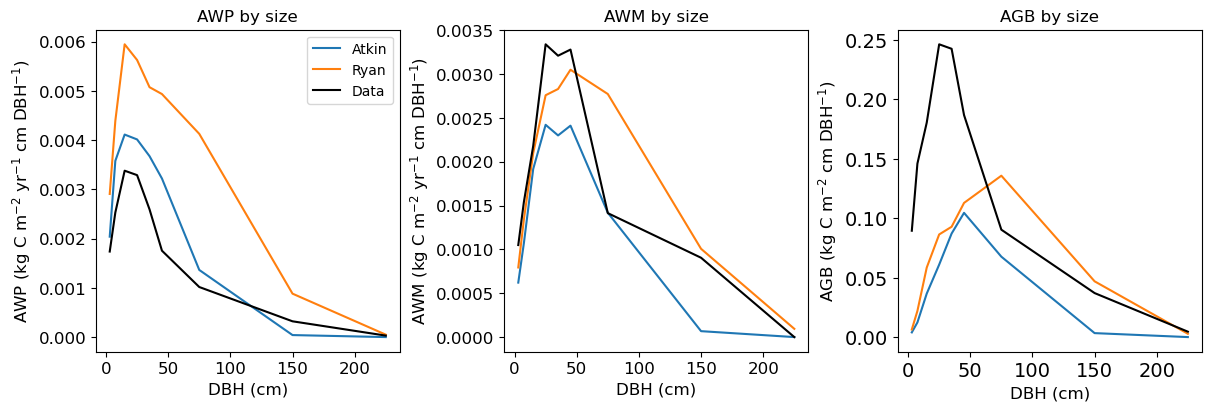

In [22]:
fig2, ((f2ax0, f2ax1, f2ax2)) = plt.subplots(nrows=1,ncols=3, figsize=(12,4), constrained_layout=True)
 
### AGW Productivity
f2ax0.plot(fates_sizebin_mids, fates_awp,  label = 'Atkin')
f2ax0.plot(fates_sizebin_mids, fates_awp_def,  label = 'Ryan')
f2ax0.plot(fates_sizebin_mids, AWP * 1000 / 10000 / 2 / fates_sizebin_widths,  label = 'Data', color='black')
f2ax0.set_title(r'AWP by size', fontsize = 12)
f2ax0.set_ylabel('AWP (kg C m$^{-2}$ yr$^{-1}$ cm DBH$^{-1}$)', fontsize = 12)
f2ax0.set_xlabel('DBH (cm)', fontsize = 12)
f2ax0.tick_params(labelsize=12)
f2ax0.legend()
        
### AGW Mortality
f2ax1.plot(fates_sizebin_mids, fates_awm)
f2ax1.plot(fates_sizebin_mids, fates_awm_def)
f2ax1.plot(fates_sizebin_mids, AWM * 1000 / 10000 / 2 / fates_sizebin_widths, color='black')
f2ax1.set_title(r'AWM by size', fontsize = 12)
f2ax1.set_xlabel('DBH (cm)', fontsize = 12)
f2ax1.set_ylabel('AWM (kg C m$^{-2}$ yr$^{-1}$ cm DBH$^{-1}$)', fontsize = 12)
f2ax1.tick_params(labelsize=12)

### AGB
f2ax2.plot(fates_sizebin_mids, fates_agb)
f2ax2.plot(fates_sizebin_mids, fates_agb_def)
f2ax2.plot(fates_sizebin_mids, AGB * 1000 / 10000 / 2 /fates_sizebin_widths, color='black')
f2ax2.set_title(r'AGB by size', fontsize = 12)
f2ax2.set_xlabel('DBH (cm)', fontsize = 12)
f2ax2.set_ylabel('AGB (kg C m$^{-2}$ cm DBH$^{-1}$)', fontsize = 12)
f2ax2.tick_params(labelsize=14)
        
plt.savefig("Figures/BCI_piponiot_ryan_atkin.png", format = 'png', dpi = 300, facecolor='white', edgecolor='white')
